<a href="https://colab.research.google.com/github/reiinakano/diff-painter/blob/master/notebooks/train_vae_painter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optionally connect to Google Drive

In [7]:
#from google.colab import drive
#drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


# Install MyPaint and other dependencies

In [0]:
# Install mypaint
!apt-get update
!apt-get install libjson-c-dev libgirepository1.0-dev libglib2.0-dev
!apt-get install autotools-dev intltool gettext libtool
!apt-get install swig python-setuptools gettext g++
!apt-get install -y libgtk-3-dev python-gi-dev
!apt-get install -y libpng-dev liblcms2-dev libjson-c-dev
!apt-get install -y gir1.2-gtk-3.0 python-gi-cairo
!apt-get install scons

!wget https://github.com/mypaint/libmypaint/releases/download/v1.3.0/libmypaint-1.3.0.tar.xz
!tar -xvf libmypaint-1.3.0.tar.xz
!mv libmypaint-1.3.0 libmypaint

!cd libmypaint && ./configure && make install

!wget https://github.com/mypaint/mypaint/releases/download/v1.2.1/mypaint-1.2.1.tar.xz
!tar -xvf mypaint-1.2.1.tar.xz
!mv mypaint-1.2.1 mypaint
!cd mypaint && scons && scons install

!ldconfig

!pip install ipdb tqdm pathlib cloudpickle matplotlib

In [3]:
!pip install future-fstrings

In [4]:
!git clone https://github.com/reiinakano/SPIRAL-tensorflow.git
!cd SPIRAL-tensorflow && git checkout reiinakano-patch-2  #reiinakano-patches
!cd SPIRAL-tensorflow && git pull

Cloning into 'SPIRAL-tensorflow'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 154 (delta 3), reused 0 (delta 0), pack-reused 146
Receiving objects: 100% (154/154), 1.36 MiB | 2.88 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Branch 'reiinakano-patch-2' set up to track remote branch 'reiinakano-patch-2' from 'origin'.
Switched to a new branch 'reiinakano-patch-2'
Already up to date.


In [5]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-04-11 12:14:52--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.66.95, 34.206.253.53, 54.174.228.92, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.66.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  14.4MB/s    in 1.0s    

2019-04-11 12:14:53 (14.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


# Download episodes. 

If you want to generate your own brushstrokes, go to https://github.com/reiinakano/diff-painter/blob/master/notebooks/generate_stroke_examples.ipynb or put your data under the data/ folder 

In [8]:
!mkdir data
#!mkdir tf_vae
!cp /drive/My\ Drive/world-painter5/episodes_*.npz data/
#!cp /drive/My\ Drive/world-painter5/tf_vae/* tf_vae/
#!cp -r /drive/My\ Drive/world-painter5/logdir_tf_vae logdir

mkdir: cannot create directory ‘data’: File exists


#imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

import tensorflow as tf
import os

import sys
sys.path.append('mypaint')
sys.path.append('SPIRAL-tensorflow')

from lib import surface, tiledsurface, brush
from envs.mypaint_utils import *

from IPython.display import display

import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import matplotlib.pyplot as plt


# 

In [0]:
class args:
  jump=True
  curve=True
  screen_size=64
  location_size=32
  color_channel=3
  brush_path='SPIRAL-tensorflow/assets/brushes/dry_brush.myb'
  train=True
  data_dir=Path('data')

# painting environment

In [0]:
class PaintMode:
  STROKES_ONLY = 0
  JUMP_STROKES = 1
  CONNECTED_STROKES = 2

class ColorEnv():
    head = 0.25
    tail = 0.75
    
    # all 0 to 1
    actions_to_idx = {
        'pressure': 0,
        'size': 1,
        'control_x': 2,
        'control_y': 3,
        'end_x': 4,
        'end_y': 5,
        'color_r': 6,
        'color_g': 7,
        'color_b': 8,
        'start_x': 9,
        'start_y': 10,
        'entry_pressure': 11,
    }

    def __init__(self, args, paint_mode=PaintMode.JUMP_STROKES):
        self.args = args
        self.paint_mode = paint_mode

        # screen
        self.screen_size = args.screen_size
        self.height, self.width = self.screen_size, self.screen_size
        self.observation_shape = [
                self.height, self.width, args.color_channel]

        # location
        self.location_size = args.location_size
        self.location_shape = [self.location_size, self.location_size]
        
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None
    
    @staticmethod
    def pretty_print_action(ac):
        for k, v in ColorEnv.actions_to_idx.items():
            print(k, ac[v])
    
    def random_action(self):
        return np.random.uniform(size=[len(self.actions_to_idx)])
      
    def reset(self):
        self.intermediate_images = []
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None

        self.s = tiledsurface.Surface()
        self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
        self.s.begin_atomic()

        with open(self.args.brush_path) as fp:
            self.bi = brush.BrushInfo(fp.read())
        self.b = brush.Brush(self.bi)

    def draw(self, ac, s=None, dtime=1):
        # Just added this
        if self.paint_mode == PaintMode.STROKES_ONLY:
          self.s.clear()
          self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
          self.s.end_atomic()
          self.s.begin_atomic()
        
        if s is None:
            s = self.s

        s_x, s_y = ac[self.actions_to_idx['start_x']]*64, ac[self.actions_to_idx['start_y']]*64  
        e_x, e_y = ac[self.actions_to_idx['end_x']]*64, ac[self.actions_to_idx['end_y']]*64
        c_x, c_y = ac[self.actions_to_idx['control_x']]*64, ac[self.actions_to_idx['control_y']]*64
        color = (
            ac[self.actions_to_idx['color_r']],
            ac[self.actions_to_idx['color_g']],
            ac[self.actions_to_idx['color_b']],
        )
        pressure = ac[self.actions_to_idx['pressure']]*0.8
        entry_pressure = ac[self.actions_to_idx['entry_pressure']]*0.8
        size = ac[self.actions_to_idx['size']] * 2.
        
        if self.paint_mode == PaintMode.CONNECTED_STROKES:
            if self.prev_x is not None:
                s_x, s_y, entry_pressure = self.prev_x, self.prev_y, self.prev_pressure
            self.prev_x, self.prev_y, self.prev_pressure = e_x, e_y, pressure

        self.b.brushinfo.set_color_rgb(color)
        
        self.b.brushinfo.set_base_value('radius_logarithmic', size)

        # Move brush to starting point without leaving it on the canvas.
        self._stroke_to(s_x, s_y, 0)

        self._draw(s_x, s_y, e_x, e_y, c_x, c_y, entry_pressure, pressure, size, color, dtime)

    def _draw(self, s_x, s_y, e_x, e_y, c_x, c_y,
              entry_pressure, pressure, size, color, dtime):

        # if straight line or jump
        if pressure == 0:
            self.b.stroke_to(
                    self.s.backend, e_x, e_y, pressure, 0, 0, dtime)
        else:
            self.curve(c_x, c_y, s_x, s_y, e_x, e_y, entry_pressure, pressure)
            
        # Relieve brush pressure for next jump
        self._stroke_to(e_x, e_y, 0)

        self.s.end_atomic()
        self.s.begin_atomic()

    # sx, sy = starting point
    # ex, ey = end point
    # kx, ky = curve point from last line
    # lx, ly = last point from InteractionMode update
    def curve(self, cx, cy, sx, sy, ex, ey, entry_pressure, pressure):
        #entry_p, midpoint_p, junk, prange2, head, tail
        entry_p, midpoint_p, prange1, prange2, h, t = \
                self._line_settings(entry_pressure, pressure)

        points_in_curve = 100
        mx, my = midpoint(sx, sy, ex, ey)
        length, nx, ny = length_and_normal(mx, my, cx, cy)
        cx, cy = multiply_add(mx, my, nx, ny, length*2)
        x1, y1 = difference(sx, sy, cx, cy)
        x2, y2 = difference(cx, cy, ex, ey)
        head = points_in_curve * h
        head_range = int(head)+1
        tail = points_in_curve * t
        tail_range = int(tail)+1
        tail_length = points_in_curve - tail

        # Beginning
        px, py = point_on_curve_1(1, cx, cy, sx, sy, x1, y1, x2, y2)
        length, nx, ny = length_and_normal(sx, sy, px, py)
        bx, by = multiply_add(sx, sy, nx, ny, 0.25)
        self._stroke_to(bx, by, entry_p)
        pressure = abs(1/head * prange1 + entry_p)
        self._stroke_to(px, py, pressure)

        for i in xrange(2, head_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs(i/head * prange1 + entry_p)
            self._stroke_to(px, py, pressure)

        # Middle
        for i in xrange(head_range, tail_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            self._stroke_to(px, py, midpoint_p)

        # End
        for i in xrange(tail_range, points_in_curve+1):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs((i-tail)/tail_length * prange2 + midpoint_p)
            self._stroke_to(px, py, pressure)

        return pressure

    def _stroke_to(self, x, y, pressure, duration=0.1):
        self.b.stroke_to(
                self.s.backend,
                x, y,
                pressure,
                0.0, 0.0,
                duration)
        self.s.end_atomic()
        self.s.begin_atomic()
        self.intermediate_images.append(self.image)

    def save_image(self, path="test.png"):
        Image.fromarray(self.image.astype(np.uint8).squeeze()).save(path)
        #self.s.save_as_png(path, alpha=False)

    @property
    def image(self):
        rect = [0, 0, self.height, self.width]
        scanline_strips = \
                surface.scanline_strips_iter(self.s, rect)
        return next(scanline_strips)

    def _line_settings(self, entry_pressure, pressure):
        p1 = entry_pressure
        p2 = (entry_pressure + pressure) / 2
        p3 = pressure
        if self.head == 0.0001:
            p1 = p2
        prange1 = p2 - p1
        prange2 = p3 - p2
        return p1, p2, prange1, prange2, self.head, self.tail


# Sanity check data

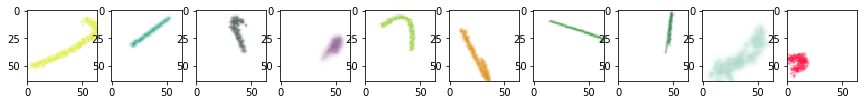

In [4]:
loaded = np.load('data/episodes_0.npz')

w=args.screen_size
h=args.screen_size
fig=plt.figure(figsize=(30, 10))
cols = 10

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    #print(img.shape)
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

In [5]:
for ac in loaded['actions'][:cols]:
  print('___')
  ColorEnv.pretty_print_action(ac)

___
('end_y', 0.7956261733544399)
('end_x', 0.0719896371238532)
('color_g', 0.9295171381477916)
('color_b', 0.327325016661421)
('pressure', 0.7016299969570069)
('entry_pressure', 0.791512122280226)
('color_r', 0.8850787301412161)
('size', 0.3078098070978178)
('control_y', 0.3821322692018977)
('control_x', 0.9056736538771794)
('start_x', 0.8012315384848907)
('start_y', 0.13205111491701982)
___
('end_y', 0.504413715287214)
('end_x', 0.28868259517478045)
('color_g', 0.5709039312649203)
('color_b', 0.46340333469497996)
('pressure', 0.2863948560610854)
('entry_pressure', 0.17021552902115167)
('color_r', 0.03936242643496768)
('size', 0.565083587620296)
('control_y', 0.34304069041323104)
('control_x', 0.5099357257911145)
('start_x', 0.8272772159918103)
('start_y', 0.10557960314008707)
___
('end_y', 0.19765549622445455)
('end_x', 0.6396484251012181)
('color_g', 0.3951372944849686)
('color_b', 0.3583289012342826)
('pressure', 0.8820556863638158)
('entry_pressure', 0.2468142120456086)
('color_r'

# VAE Neural Painter

In [0]:
class ConvVAE(object):
  def __init__(self, z_size=64, batch_size=100, learning_rate=0.0001, kl_tolerance=0.5, is_training=True, reuse=False, gpu_mode=True, graph=None):
    self.z_size = z_size
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.kl_tolerance = kl_tolerance
    self.reuse = reuse
    # Is it okay to comment this out? with tf.variable_scope('conv_vae', reuse=self.reuse):
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.logging.info('conv_vae using cpu.')
        self._build_graph(graph)
    else:
      tf.logging.info('conv_vae using gpu.')
      self._build_graph(graph)
    self._init_session()
  
  def build_decoder(self, z, reuse=False):
    with tf.variable_scope('decoder', reuse=reuse):
      h = tf.layers.dense(z, 4*256, name="fc")
      h = tf.reshape(h, [-1, 1, 1, 4*256])
      h = tf.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="deconv1")
      h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="deconv2")
      h = tf.layers.conv2d_transpose(h, 32, 6, strides=2, activation=tf.nn.relu, name="deconv3")
      return tf.layers.conv2d_transpose(h, 3, 6, strides=2, activation=tf.nn.sigmoid, name="deconv4")
  
  def build_predictor(self, actions, reuse=False, is_training=False):
    with tf.variable_scope('predictor', reuse=reuse):
      h = tf.layers.dense(actions, 256, activation=tf.nn.leaky_relu, name="fc1")
      h = tf.layers.batch_normalization(h, training=is_training, name="bn1")
      h = tf.layers.dense(h, 64, activation=tf.nn.leaky_relu, name="fc2")
      h = tf.layers.batch_normalization(h, training=is_training, name="bn2")
      h = tf.layers.dense(h, 64, activation=tf.nn.leaky_relu, name="fc3")
      h = tf.layers.batch_normalization(h, training=is_training, name="bn3")
      return tf.layers.dense(h, self.z_size, name='fc4')
  
  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
    with self.g.as_default(), tf.variable_scope('conv_vae', reuse=self.reuse):

      #### autoencoding part
      self.x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
      
      # Encoder
      h = tf.layers.conv2d(self.x, 32, 4, strides=2, activation=tf.nn.relu, name="enc_conv1")
      h = tf.layers.conv2d(h, 64, 4, strides=2, activation=tf.nn.relu, name="enc_conv2")
      h = tf.layers.conv2d(h, 128, 4, strides=2, activation=tf.nn.relu, name="enc_conv3")
      h = tf.layers.conv2d(h, 256, 4, strides=2, activation=tf.nn.relu, name="enc_conv4")
      h = tf.reshape(h, [-1, 2*2*256])

      # VAE
      self.mu = tf.layers.dense(h, self.z_size, name="enc_fc_mu")
      self.logvar = tf.layers.dense(h, self.z_size, name="enc_fc_log_var")
      self.sigma = tf.exp(self.logvar / 2.0)
      #self.epsilon = tf.random_normal([self.batch_size, self.z_size])
      self.epsilon = tf.random_normal([tf.shape(self.sigma)[0], self.z_size])
      self.z = self.mu + self.sigma * self.epsilon

      # Decoder
      self.y = self.build_decoder(self.z)
      
      #### predicting part
      self.actions = tf.placeholder(tf.float32, shape=[None, 12])
      self.predicted_z = self.build_predictor(self.actions, is_training=self.is_training)
      self.predicted_y = self.build_decoder(self.predicted_z, reuse=True)
      
      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.uneven_multiplier = tf.placeholder_with_default(1.0, [])
        summ_uneven_mult = tf.summary.scalar('uneven_multiplier', self.uneven_multiplier)

        eps = 1e-6 # avoid taking log of zero
        
        mask = tf.reduce_mean(
          self.x,
          reduction_indices = [3]
        )
        stroke_whitespace = tf.equal(mask, 1.0)
        mask = tf.where(stroke_whitespace, tf.ones(tf.shape(mask)), self.uneven_multiplier*tf.ones(tf.shape(mask)))
        mask = tf.reshape(mask, [-1, 64, 64, 1])
        mask = tf.tile(mask, [1, 1, 1, 3])
        summ_mask = tf.summary.image('mask', mask, max_outputs=3)
        print(mask.get_shape())
        
        # reconstruction loss
        self.r_loss = tf.reduce_sum(
          (tf.square(self.x - self.y))*mask,
          reduction_indices = [1,2,3]
        )
        self.r_loss = tf.reduce_mean(self.r_loss)

        # augmented kl loss per dim
        self.kl_loss = - 0.5 * tf.reduce_sum(
          (1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar)),
          reduction_indices = 1
        )
        self.kl_loss = tf.maximum(self.kl_loss, self.kl_tolerance * self.z_size)
        self.kl_loss = tf.reduce_mean(self.kl_loss)
        
        summ_recon_loss = tf.summary.scalar('recon_loss', self.r_loss)
        summ_kl_loss = tf.summary.scalar('kl_loss', self.kl_loss)
        self.loss = self.r_loss + self.kl_loss
        
        # training the vae
        self.lr = tf.Variable(self.learning_rate, trainable=False)
        summ_lr = tf.summary.scalar('lr', self.lr)
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        grads = self.optimizer.compute_gradients(
            self.loss, 
            tf.global_variables('conv_vae/enc_*')+tf.global_variables('conv_vae/decoder*')) # can potentially clip gradients here.

        self.train_op = self.optimizer.apply_gradients(
          grads, global_step=self.global_step, name='train_step')
        summ_loss = tf.summary.scalar('loss', self.loss)
        
        # training the predictor
        self.predictor_loss = tf.reduce_mean(tf.square(self.predicted_z - self.z))
        self.optimizer2 = tf.train.AdamOptimizer(self.lr)
        grads2 = self.optimizer2.compute_gradients(self.predictor_loss, tf.global_variables('conv_vae/predictor*'))
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
          self.train_op2 = self.optimizer2.apply_gradients(
            grads2, global_step=self.global_step, name='train_step2')
        summ_predictor_loss = tf.summary.scalar('predictor_loss', self.predictor_loss)
      
        #summary ops
        summ_inp_img = tf.summary.image('inp_img', self.x, max_outputs=3)
        summ_output_img = tf.summary.image('output_img', self.y, max_outputs=3)
        summ_predicted_output_img = tf.summary.image('predicted_output_img', self.predicted_y, max_outputs=3)
        self.summary_op = tf.summary.merge([
            summ_inp_img, summ_output_img, summ_loss, summ_kl_loss, summ_recon_loss,
            summ_mask, summ_uneven_mult, summ_lr
        ])
        self.summary_op_2 = tf.summary.merge([
            summ_inp_img, summ_predictor_loss, summ_output_img, summ_predicted_output_img, summ_lr
        ])
        

      # initialize vars
      self.init = tf.global_variables_initializer()
  
  def generate_stroke_graph(self, actions):
    with tf.variable_scope('conv_vae', reuse=True):
      with self.g.as_default():
        # Encoder?
        z = self.build_predictor(actions, reuse=True, is_training=False)

        # Decoder
        return self.build_decoder(z, reuse=True)

  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
  def save_model(self, model_save_path='tf_vae'):
    sess = self.sess
    step = sess.run(self.global_step)
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'vae')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, step) # just keep one
  def load_checkpoint(self, checkpoint_path='tf_vae', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)
  def load_only_vae_checkpoint(self, checkpoint_path='tf_vae', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      to_save = tf.global_variables('conv_vae/enc_*')+tf.global_variables('conv_vae/decoder*')+tf.global_variables('conv_vae/conv_vae/enc_*')+tf.global_variables('conv_vae/conv_vae/decoder*')+tf.global_variables('conv_vae/global_step')
      print(to_save)
      saver = tf.train.Saver(to_save)
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)

# Training the VAE Neural painter

In [0]:
# Hyperparameters for ConvVAE
z_size=64
batch_size=100
learning_rate=0.0001
kl_tolerance=0.5

# Parameters for training
NUM_EPOCH = 5
DATA_DIR = "record"

model_save_path = "tf_vae"
if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)

In [0]:
def reset_graph():
  if 'sess' in globals() and sess:
    sess.close()
  tf.reset_default_graph()

reset_graph()

In [9]:
vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True)


INFO:tensorflow:conv_vae using gpu.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
(?, 64, 64, 3)
Instructions for updating:
Use tf.cast instead.


In [0]:
# Run this to start from a checkpoint
# vae.load_checkpoint('tf_vae')


## Running tensorboard

In [10]:
#!rm -r logdir

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format('logdir')
)

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://6a436cad.ngrok.io


In [0]:
#!kill $(lsof -t -i:6006)

## Actual training

In [0]:
# TODO: Make file loading more efficient if needed
print("train", "step", "loss", "recon_loss", "kl_loss")
episode_files = tf.gfile.Glob('data/episodes_*.npz')


train_writer = tf.summary.FileWriter('logdir', vae.sess.graph)
for epoch in range(NUM_EPOCH):
  np.random.shuffle(episode_files)
  
  ep_files = episode_files
  
  for ep_file in ep_files:
    print(ep_file)
    loaded = np.load(ep_file)
    actions = loaded['actions']
    images = loaded['strokes']
    images = np.reshape(images, [-1, 64, 64, 3])
    #images = images[:, :, :, :3]
    print(images.shape)
    num_batches = int(np.floor(len(images)/batch_size))
    print("num_batches", num_batches)

    for idx in range(num_batches):
      train_step = vae.sess.run(vae.global_step)
      
      # When training the VAE at the beginning, we add more weight on matching the non-white areas of the brushstroke
      # for the reconstructin loss. Otherwise, it will never learn.
      if train_step > 10000:
        uneven_multiplier = 1.0
      else:
        uneven_multiplier = 10.0
      
      batch = images[idx*batch_size:(idx+1)*batch_size]

      obs = batch.astype(np.float)/255.0

      feed = {vae.x: obs, 
              vae.actions: actions[idx*batch_size:(idx+1)*batch_size], 
              vae.uneven_multiplier: uneven_multiplier}

      if train_step < 200000:
        # First part of training trains the VAE
        (train_loss, _, summ) = vae.sess.run([
          vae.loss, vae.train_op, vae.summary_op
        ], feed)
      else:
        # Second part of training trains the predictor
        
        # Manually adjusted learning rate. Can probably change this to other decay strategies.
        if train_step < 220000:
          feed[vae.lr] = 0.01
        elif train_step < 280000:
          feed[vae.lr] = 0.001
        else:
          feed[vae.lr] = 0.0001
        (train_loss, _, summ) = vae.sess.run([
          vae.predictor_loss, vae.train_op2, vae.summary_op_2
        ], feed)

      if ((train_step+1) % 50 == 0):
        train_writer.add_summary(summ, train_step)
      if ((train_step+1) % 500 == 0):
        print("step", (train_step+1), train_loss)
      if ((train_step+1) % 10000 == 0):
        vae.save_model()

('train', 'step', 'loss', 'recon_loss', 'kl_loss')
data/episodes_67.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 500, 1174.2031)
('step', 1000, 898.33514)
data/episodes_28.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 1500, 885.24243)
('step', 2000, 888.0618)
data/episodes_64.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 2500, 728.4216)
('step', 3000, 657.79584)
data/episodes_13.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 3500, 691.70526)
('step', 4000, 675.4695)
data/episodes_42.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 4500, 739.1411)
('step', 5000, 742.3236)
data/episodes_30.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 5500, 755.3373)
('step', 6000, 668.58636)
data/episodes_76.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 6500, 643.5762)
('step', 7000, 460.44772)
data/episodes_73.npz
(100000, 64, 64, 3)
('num_batches', 1000)
('step', 7500, 536.8815)
('step', 8000, 495.9364)
data/episodes_15.npz
(100000, 64, 64, 3

# Test your trained model

In [0]:
loaded = np.load('data/episodes_0.npz')
images = loaded['strokes']
images = np.reshape(images[-100:], [-1, 64, 64, 3])
actions = loaded['actions'][-100:]

In [0]:
test_vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=False,
              reuse=False,
              gpu_mode=False)

INFO:tensorflow:conv_vae using cpu.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [0]:
def plot_images(images):
  h=args.screen_size
  fig=plt.figure(figsize=(16, 16))
  columns = len(images)
  rows = 1

  for i, img in enumerate(images):
    img = img[:, :, :3]
    #print(img.shape)
    fig.add_subplot(rows, columns, i+1)
    plt.grid(False)
    plt.imshow(img)
  plt.show()


('loading model', u'tf_vae/vae-300000')
INFO:tensorflow:Loading model tf_vae/vae-300000.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf_vae/vae-300000


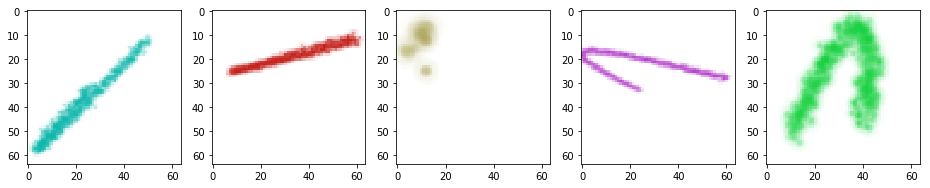

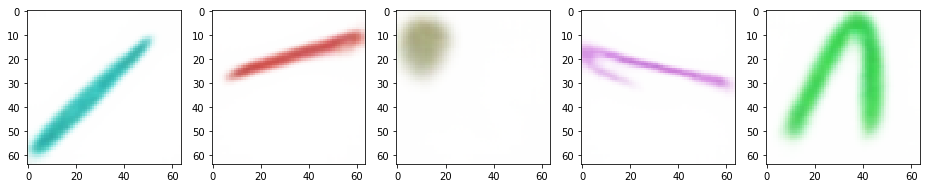

In [0]:

def experiment(to_plot, fn, actual=None):
  test_vae.load_checkpoint(fn, actual)
  images_to_plot = images[to_plot:to_plot+5].astype(np.float32)/255.
  plot_images(images_to_plot)
  decoded = test_vae.sess.run(test_vae.predicted_y, feed_dict={test_vae.actions: actions[to_plot:to_plot+5]})
  plot_images(decoded)
  
  plt.show()
  
experiment(20, 'tf_vae')


In [0]:

def experiment5(test_models, duration=10.0):
  env = ColorEnv(args, paint_mode=PaintMode.STROKES_ONLY)
  env.reset()
  
  NUM_ACS = 8
  acs = [env.random_action() for _ in range(NUM_ACS)]
  
  def frame(t):
    t_ = t / duration
    t = np.abs((1.0-np.cos(NUM_ACS*np.pi*np.mod(t_, 1./NUM_ACS)))/2.0)
    
    new_ac = (1-t)*acs[int(np.floor(t_*NUM_ACS))] + t*acs[int((np.floor(t_*NUM_ACS)+1)%NUM_ACS)]
    env.draw(new_ac)
    im = env.image
    im = im[:, :, :3]
    stack_these = []
    for test_gan in test_models:
      decoded = test_gan.sess.run(test_gan.predicted_y, feed_dict={test_gan.actions: [new_ac]})[0]
      decoded = (decoded*255).astype(np.uint8)
      concatted = np.concatenate([im, decoded], 1)
      stack_these.append(concatted)
    return np.concatenate(stack_these, axis=0)
  
  clip = mpy.VideoClip(frame, duration=duration)
  clip.write_videofile('tmp.mp4', fps=30.0)
  display(mpy.ipython_display('tmp.mp4', height=400))

  
  
_test_gans = [test_vae]
_test_gans[0].load_checkpoint('tf_vae')
experiment5(_test_gans, 20.)


('loading model', u'tf_vae/vae-300000')
INFO:tensorflow:Loading model tf_vae/vae-300000.


INFO:tensorflow:Loading model tf_vae/vae-300000.


INFO:tensorflow:Restoring parameters from tf_vae/vae-300000


INFO:tensorflow:Restoring parameters from tf_vae/vae-300000


[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 600/601 [00:08<00:00, 77.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

